In [1]:
# !pip install tensorly
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-geometric

import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [2]:
path = '/home/owner/Documents/DEV/graphs/graphs_and_structural_analysis/Santander_Product_Recommendation/train.feather'
df = pd.read_feather(path)
df

,fecha_dato,cust_id,emp_index,residence,sex,age,first_date,new_cust,seniority,is_primary,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,age_grouped,income_grouped
0,2015-01-28,1375586,N,ES,H,35.0,2015-01-12,0.0,6.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
1,2015-01-28,1050611,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
2,2015-01-28,1050612,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
3,2015-01-28,1050613,N,ES,H,22.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Ordinary
4,2015-01-28,1050614,N,ES,V,23.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Median-high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391596,2016-05-28,1166765,N,ES,V,22.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
391597,2016-05-28,1166764,N,ES,V,23.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,Low
391598,2016-05-28,1166763,N,ES,H,47.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,senior,Median-high
391599,2016-05-28,1166789,N,ES,H,22.0,2013-08-14,0.0,33.0,1.0,...,0,0,0,0,0,0.0,0.0,0,adult,High


In [3]:
col_names = {"ncodpers":"cust_id", "ind_empleado":"emp_index", "pais_residencia":"residence",
            "sexo":"sex","fecha_alta":"first_date","ind_nuevo":"new_cust","antiguedad":"seniority",
            "indrel":"is_primary","ult_fec_cli_1t":"last_primary_date","indrel_1mes":"cust_type",
            "tiprel_1mes":"cust_rel_type","indresi":"residence_index","indext":"foreigner_index",
            "conyuemp":"spouse_index","canal_entrada":"channel","cod_prov":"province","nomprov":"province_name",
            "ind_actividad_cliente":"active_index","renta":"income","segmento":"segment"
            }

df.rename(col_names, axis = 1, inplace = True)

In [4]:
df['sex'] = df['sex'].map({'H': 'M', 'V': 'F'})

In [5]:
df.age = pd.to_numeric(df.age, errors='coerce')
df.income = pd.to_numeric(df.income, errors='coerce')
df.seniority = pd.to_numeric(df.seniority, errors='coerce')
df.first_date = pd.to_datetime(df.first_date, errors = 'coerce')
df.cust_type = pd.to_numeric(df.cust_type, errors='coerce')
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])

In [6]:
# For features with missing values percentage < 10%, use the most common factor level to impute
cols = ['emp_index','residence','sex','first_date','new_cust','is_primary',"cust_type","cust_rel_type",
       "province","province_name","active_index","channel","segment"]

for i in cols:
    print(df[i].value_counts())
    df.loc[df[i].isnull(), i] = df[i].value_counts().index[0]
    
# For features with missing value accounts for over 10%, impute their missing values based on the mean at different dimensions
# For Income, impute the missings using the medians of Customer Segment and Province
df['income'].fillna(df['income'].mean(), inplace = True)

emp_index
N    13638711
B        3566
F        2523
A        2492
S          17
Name: count, dtype: int64
residence
ES    13581444
FR        5161
AR        4835
DE        4625
GB        4605
        ...   
ZW          11
DJ          11
JM          11
BM           6
MT           2
Name: count, Length: 118, dtype: int64
sex
F    7452056
M    6195253
Name: count, dtype: int64
first_date
2014-07-28    85123
2014-10-03    54287
2014-08-04    45746
2013-10-14    40804
2013-08-03    33414
              ...  
2014-04-27       11
2015-05-31        9
2014-05-01        7
2010-07-04        4
2009-12-25        4
Name: count, Length: 6756, dtype: int64
new_cust
0.0    12836102
1.0      811207
Name: count, dtype: int64
is_primary
1.0     13622516
99.0       24793
Name: count, dtype: int64
cust_type
1.0    13641336
3.0        4350
2.0        1317
4.0         306
Name: count, dtype: int64
cust_rel_type
I    7454656
A    6187123
P       4656
R        870
N          4
Name: count, dtype: int64
province
2

/tmp/ipykernel_98275/1233054225.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['income'].fillna(df['income'].mean(), inplace = True)


In [7]:
# filling dummies with NA by 0
dummies = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
          'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
          'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
          'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
          'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
          'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
          'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
          'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
          'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
          'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
          'ind_viv_fin_ult1', 'ind_nomina_ult1',
          'ind_nom_pens_ult1', 'ind_recibo_ult1']

df[dummies] = df[dummies].fillna(0)

In [8]:
# Drop the last primary date and spouse index fields given over 99% missing values
# df.drop(['last_primary_date','spouse_index'], axis = 1, inplace = True)

# Инжиниринг фич

In [9]:
# 1) Age group: group the age for lifestages: young, adult, senior, elder
age_group = [0, 20, 45, 65, 100]
age_labels = ['young', 'adult', 'senior', 'elder']

df['age_grouped'] = pd.cut(df.age, bins = age_group, labels = age_labels)

In [10]:
# 2) Income Group: group the incomes at Low, Ordinary, Median-high and High classes at (real case may be more complex)
import numpy as np
df_income_group = [0, np.nanpercentile(df['income'], 25), np.nanpercentile(df['income'], 50), np.nanpercentile(df['income'], 75), np.nanpercentile(df['income'], 100)]
income_labels = ['Low','Ordinary','Median-high','High']

df['income_grouped'] = pd.cut(df['income'], df_income_group, labels = income_labels)

In [11]:
# categorical = df.columns[(df.dtypes == "object") | (df.dtypes == "category")]
# for column in categorical:
#     df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
#     df.drop(columns=column, inplace=True)

In [12]:
print("[", end="")
for column in df.columns: print(f"{column}, ", end="")
print("]")

[fecha_dato, cust_id, emp_index, residence, sex, age, first_date, new_cust, seniority, is_primary, cust_type, cust_rel_type, residence_index, foreigner_index, channel, indfall, tipodom, province, province_name, active_index, income, segment, ind_ahor_fin_ult1, ind_aval_fin_ult1, ind_cco_fin_ult1, ind_cder_fin_ult1, ind_cno_fin_ult1, ind_ctju_fin_ult1, ind_ctma_fin_ult1, ind_ctop_fin_ult1, ind_ctpp_fin_ult1, ind_deco_fin_ult1, ind_deme_fin_ult1, ind_dela_fin_ult1, ind_ecue_fin_ult1, ind_fond_fin_ult1, ind_hip_fin_ult1, ind_plan_fin_ult1, ind_pres_fin_ult1, ind_reca_fin_ult1, ind_tjcr_fin_ult1, ind_valo_fin_ult1, ind_viv_fin_ult1, ind_nomina_ult1, ind_nom_pens_ult1, ind_recibo_ult1, age_grouped, income_grouped, ]


In [13]:
for dummy1 in dummies:
    for dummy2 in dummies:
        if dummy1 == dummy2: continue
        df[dummy2] = (~df[dummy1].astype(bool)) & df[dummy2].astype(bool)

In [14]:
df['service_name'] = pd.from_dummies(df[dummies], default_category="Unknown")

In [15]:
df['service_name'].value_counts()

service_name
ind_cco_fin_ult1     8944592
Unknown              2556239
ind_cno_fin_ult1      990121
ind_ctop_fin_ult1     455594
ind_ecue_fin_ult1     141397
                      ...   
ind_cder_fin_ult1       1439
ind_ahor_fin_ult1       1396
ind_deme_fin_ult1        686
ind_nom_pens_ult1        425
ind_aval_fin_ult1        316
Name: count, Length: 25, dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['service_id'] = le.fit_transform(df['service_name'])

# Постобработка

In [17]:
products_by_age_groups = df.groupby('age_grouped')['service_name'].value_counts()
products_by_age_groups = products_by_age_groups.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

/tmp/ipykernel_98275/3208196923.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  products_by_age_groups = df.groupby('age_grouped')['service_name'].value_counts()
/tmp/ipykernel_98275/3208196923.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  products_by_age_groups = products_by_age_groups.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)


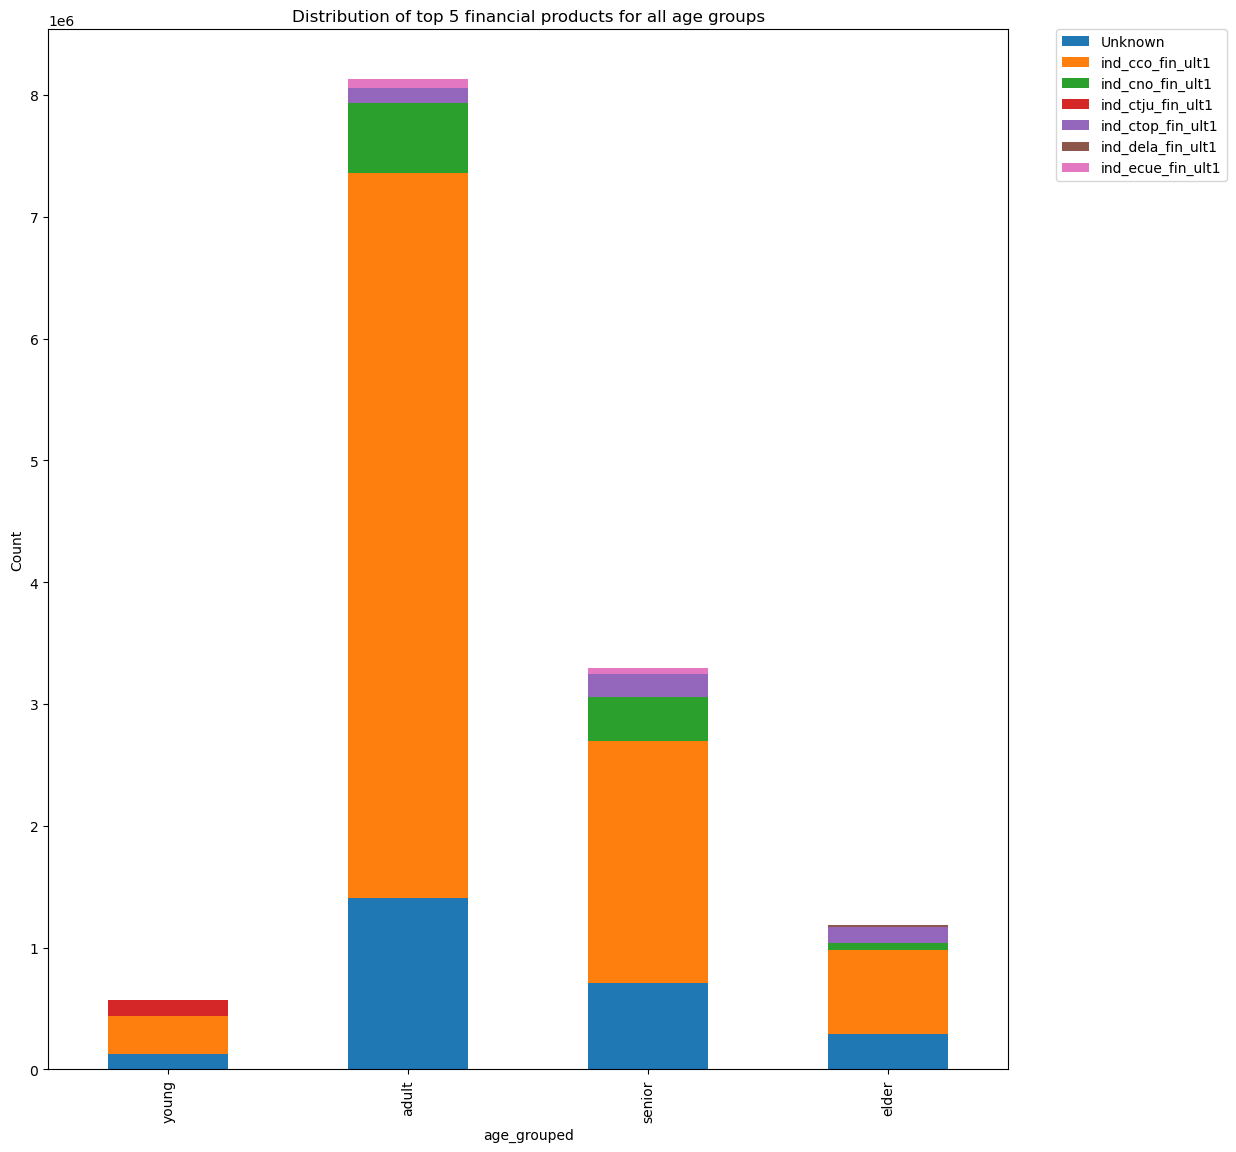

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_age_groups.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for all age groups')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [19]:
products_by_sex = df.groupby('sex')['service_name'].value_counts()
products_by_sex = products_by_sex.groupby(level=0).head(5).unstack().fillna(0).sort_index(axis=1)

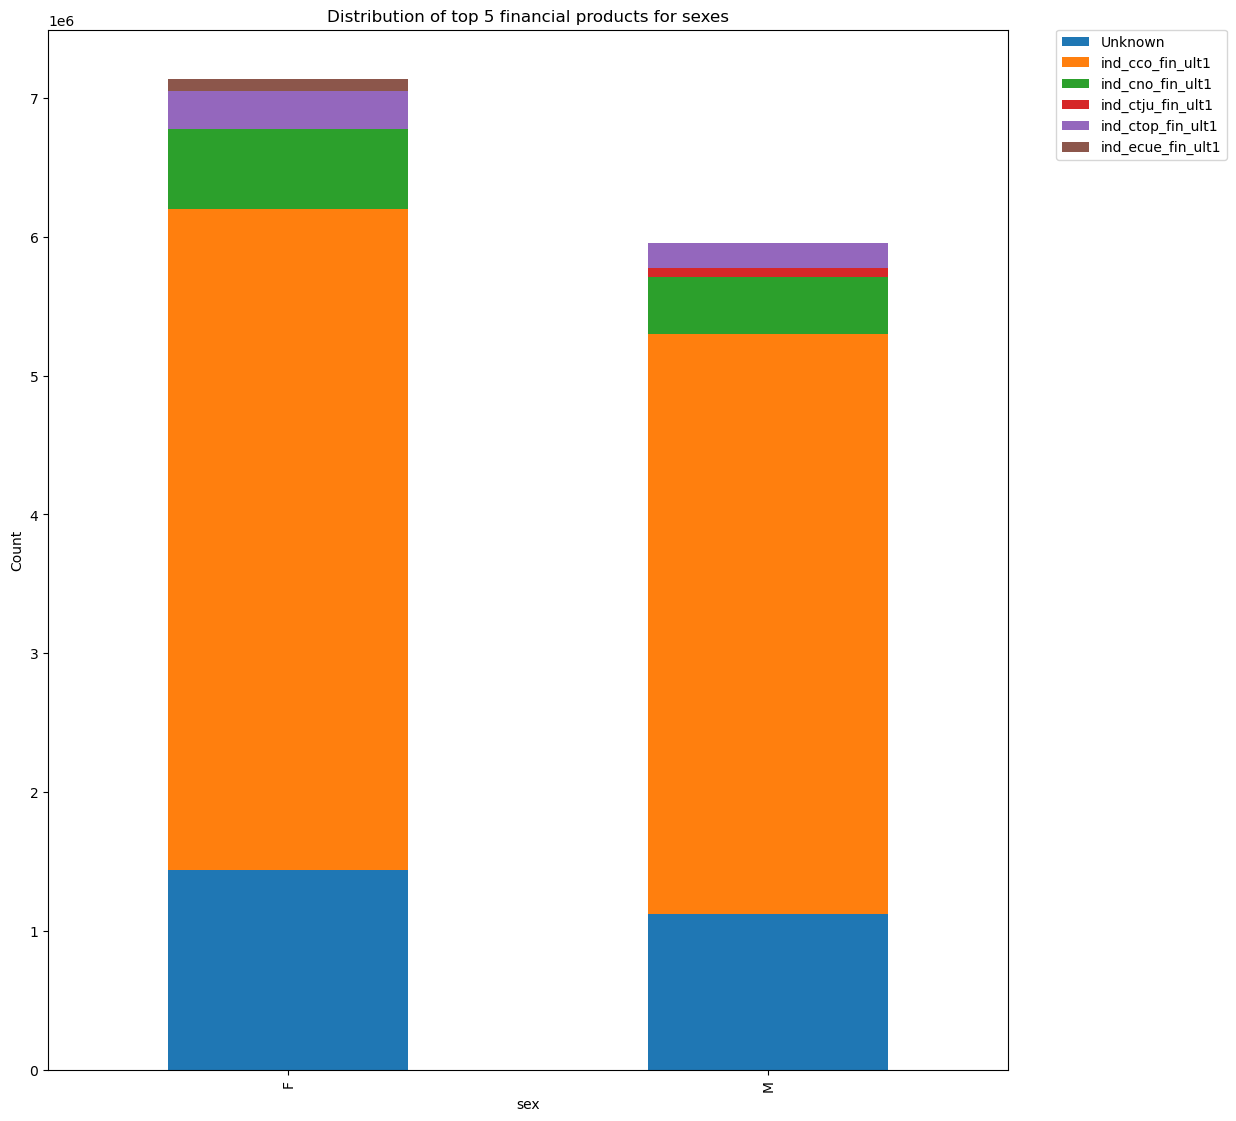

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
products_by_sex.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of top 5 financial products for sexes')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [21]:
df.columns

Index(['fecha_dato', 'cust_id', 'emp_index', 'residence', 'sex', 'age',
       'first_date', 'new_cust', 'seniority', 'is_primary', 'cust_type',
       'cust_rel_type', 'residence_index', 'foreigner_index', 'channel',
       'indfall', 'tipodom', 'province', 'province_name', 'active_index',
       'income', 'segment', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1', 'age_grouped', 'income_grouped', 'service_name',
       'service_id'],
      dtype='object')

In [22]:
data = df[['cust_id', 'service_name', 'service_id']].rename({'cust_id': 'customer_id'}, axis = 1)

In [23]:
data = data.sample(len(data) // 100)
data

,customer_id,service_name,service_id
340065,1353064,ind_cco_fin_ult1,3
337518,436020,Unknown,0
350951,788669,ind_cco_fin_ult1,3
98722,1327869,ind_cco_fin_ult1,3
226026,239123,ind_ctop_fin_ult1,8
...,...,...,...
72949,1286954,ind_cco_fin_ult1,3
67524,68681,Unknown,0
236848,1217199,ind_cco_fin_ult1,3
92195,1082217,ind_cco_fin_ult1,3


In [24]:
import networkx as nx
G = nx.Graph()

In [25]:
user_nodes = data['customer_id'].unique()
item_nodes = data['service_id'].unique()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(item_nodes, bipartite=1)
for user, item in zip(data['customer_id'], data['service_id']):
    G.add_edge(user, item, weight=1)

nx.write_gexf(G, 'graph.gexf')

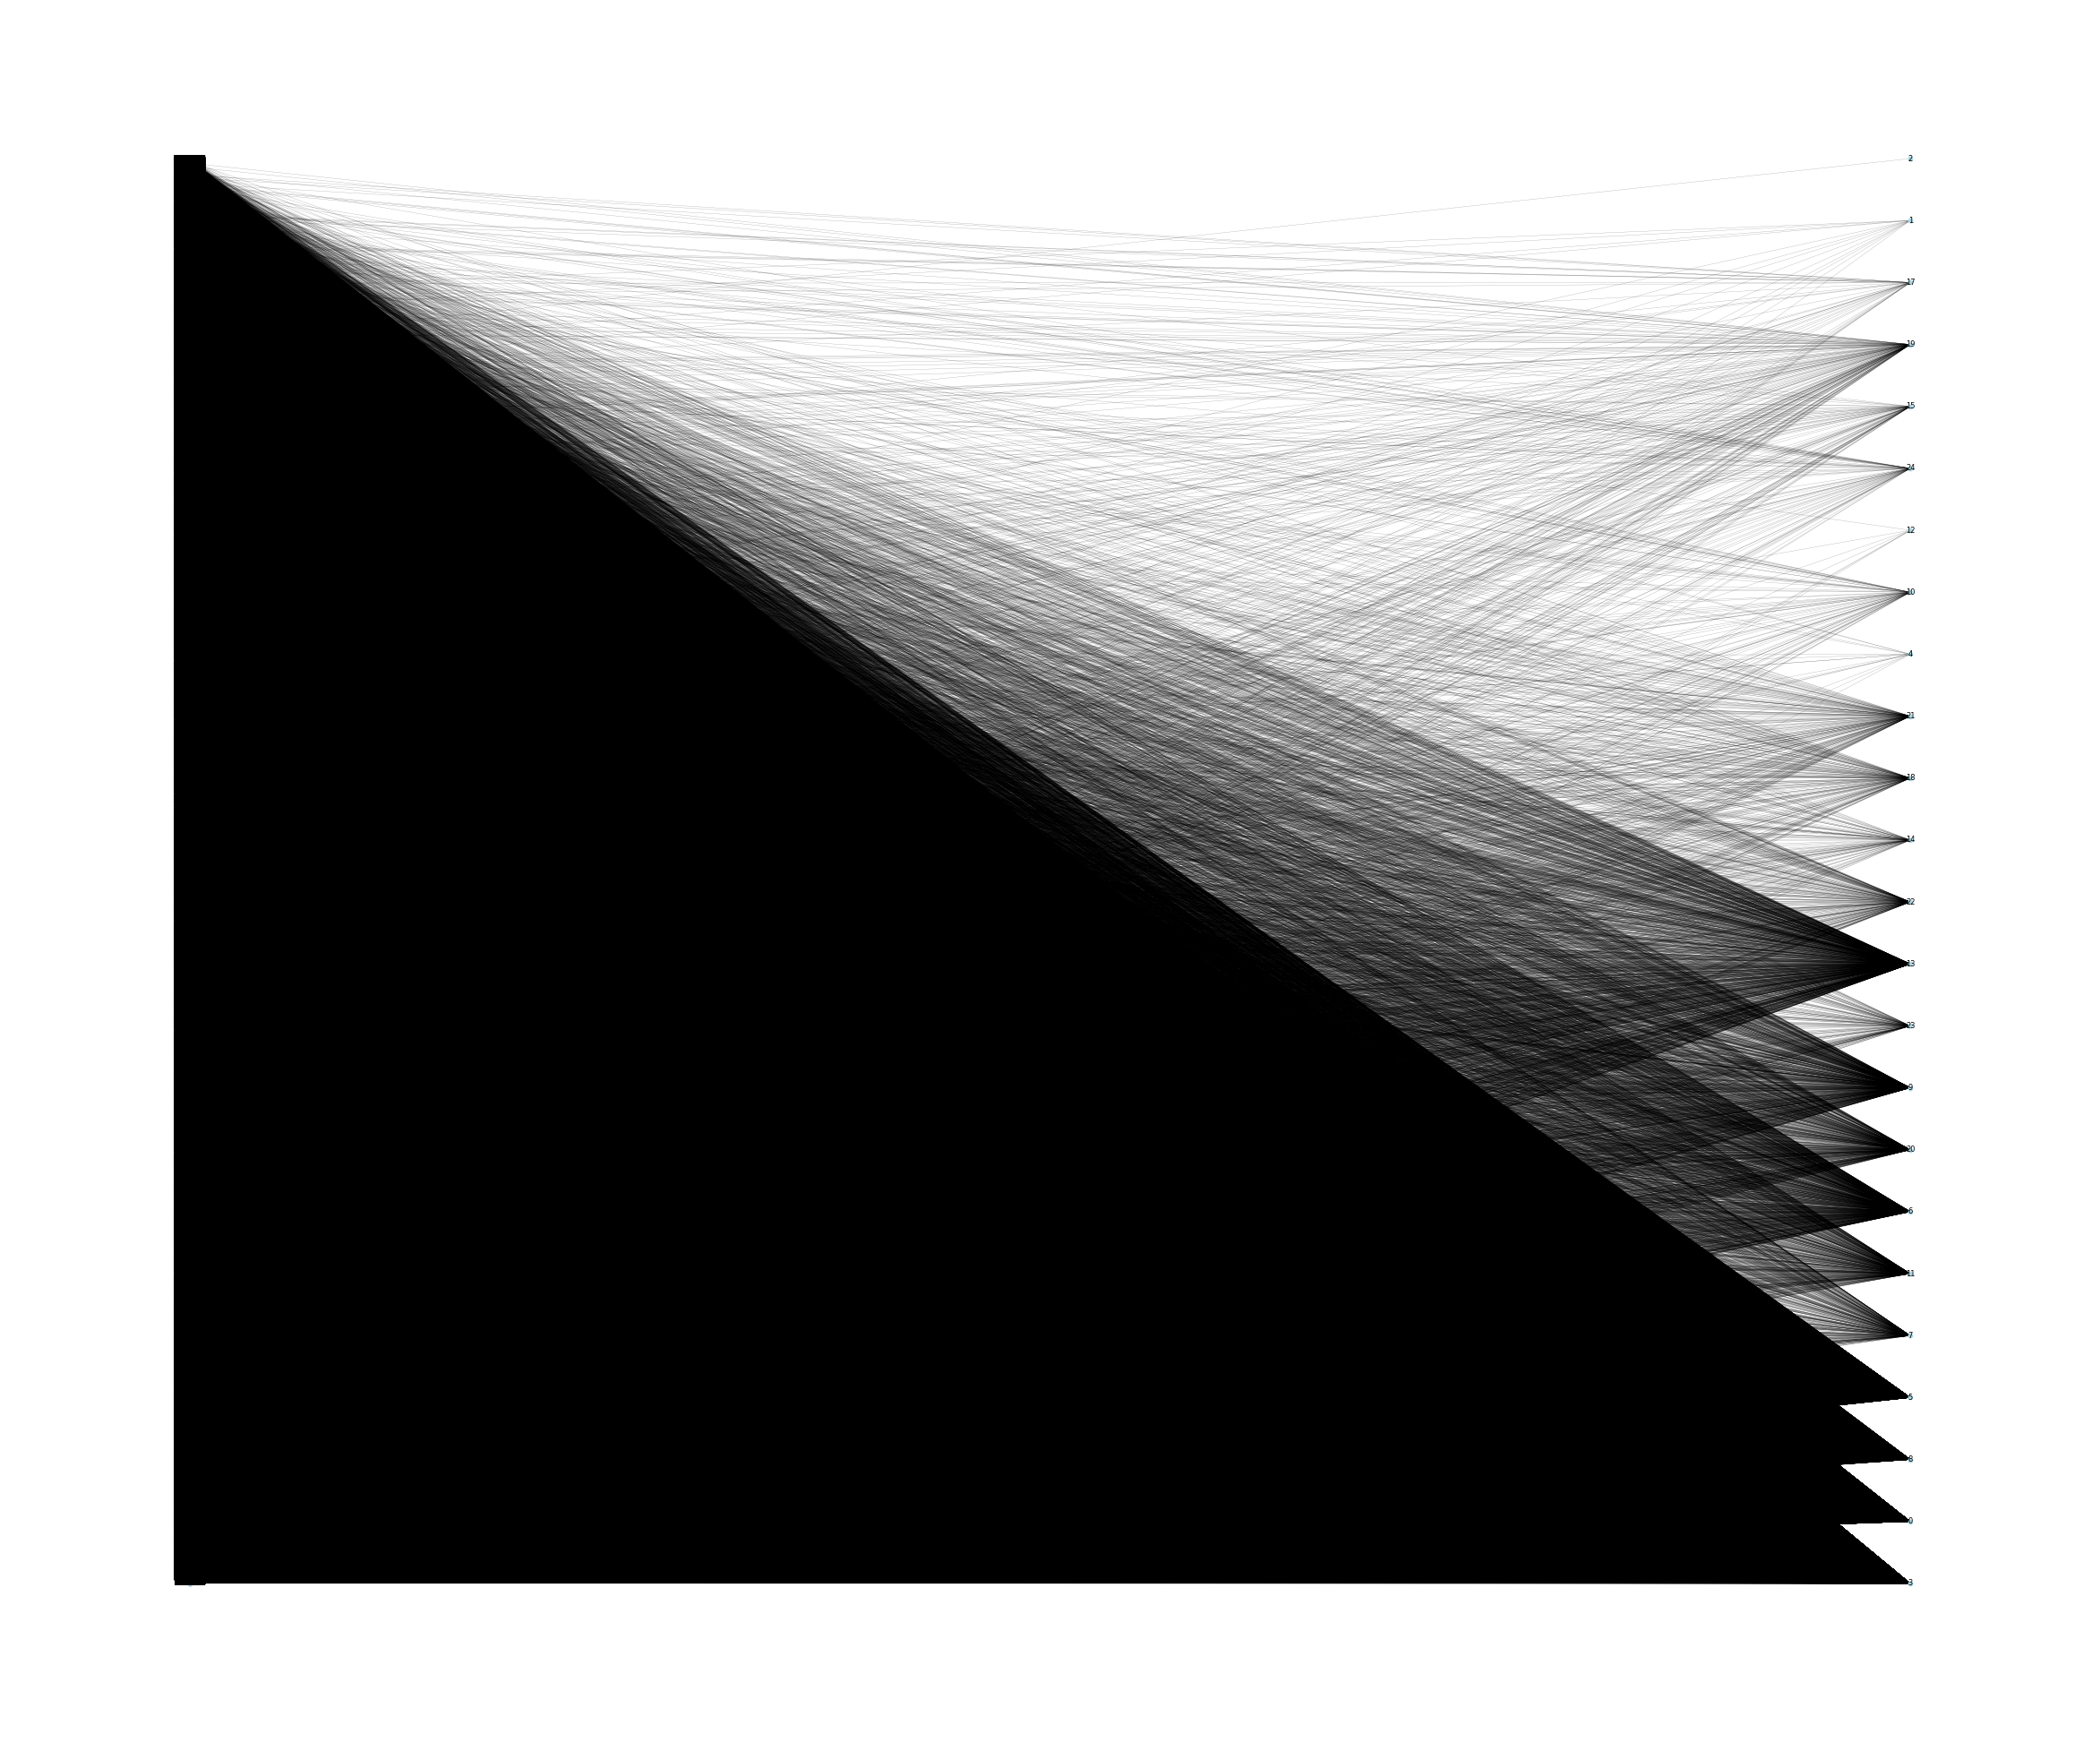

In [26]:
plt.figure(figsize=(30, 25))
pos = nx.bipartite_layout(G, nodes = user_nodes, )
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')
plt.axis('off')
plt.show()

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

In [27]:
from recommender import LightGCN_recommender

In [28]:
args = {'model_type': 'LightGCN', 'num_layers': 3, 'batch_size': 32, 'hidden_dim': 32,
         'dropout': 0, 'epochs': 1000, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3,
         'lr': 0.1, 'lambda_reg': 1e-4}
recommender = LightGCN_recommender(args=args)

{'model_type': 'LightGCN', 'num_layers': 3, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0, 'epochs': 1000, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.1, 'lambda_reg': 0.0001}


In [29]:
recommender.fit(data)

Epoch: 001, Loss: 1.3780, Val: 0.9999, Test: 0.9999, Elapsed time: 93.95
Epoch: 002, Loss: 1.3238, Val: 0.9999, Test: 0.9999, Elapsed time: 95.73
Epoch: 003, Loss: 1.2734, Val: 0.9999, Test: 0.9999, Elapsed time: 94.19
Epoch: 004, Loss: 1.2218, Val: 0.9999, Test: 0.9999, Elapsed time: 98.84
Epoch: 005, Loss: 1.1722, Val: 0.9999, Test: 0.9999, Elapsed time: 95.20
Epoch: 006, Loss: 1.1248, Val: 0.9999, Test: 0.9999, Elapsed time: 95.06
Epoch: 007, Loss: 1.0799, Val: 0.9999, Test: 0.9999, Elapsed time: 96.77
Epoch: 008, Loss: 1.0356, Val: 1.0000, Test: 1.0000, Elapsed time: 95.74
Epoch: 009, Loss: 0.9938, Val: 1.0000, Test: 1.0000, Elapsed time: 95.75
Epoch: 010, Loss: 0.9532, Val: 1.0000, Test: 1.0000, Elapsed time: 95.85
Epoch: 011, Loss: 0.9144, Val: 1.0000, Test: 1.0000, Elapsed time: 96.04
Epoch: 012, Loss: 0.8790, Val: 1.0000, Test: 1.0000, Elapsed time: 96.28
Epoch: 013, Loss: 0.8427, Val: 1.0000, Test: 1.0000, Elapsed time: 96.02
Epoch: 014, Loss: 0.8087, Val: 1.0000, Test: 1.0000

In [30]:
import pickle

with open('recommender_data.pkl', 'wb') as outp:
    pickle.dump(recommender, outp)

In [31]:
recommender.recommend(1, 10)

[3,
 0,
 5,
 8,
 13,
 6,
 9,
 20,
 11,
 7,
 22,
 21,
 18,
 23,
 19,
 14,
 15,
 10,
 24,
 17,
 4,
 1,
 12,
 2]